<a href="https://colab.research.google.com/github/LeaCarop/NeuralNets/blob/main/NeuralNets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Run on TensorFlow 2.x
%tensorflow_version 2.x
from __future__ import absolute_import, division, print_function, unicode_literals

**Cargar librerías**

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from matplotlib import pyplot as plt
import seaborn as sns

# The following lines adjust the granularity of reporting. 
pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.1f}".format

**Descargar Dataset**

In [ ]:
train_df = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv")
train_df = train_df.reindex(np.random.permutation(train_df.index)) # mezclar los ejemplos
test_df = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_test.csv")

**Normalizar valores**

La siguiente celda de código normaliza los conjuntos de datos convirtiendo cada valor sin procesar en su puntuación Z. 

In [ ]:
# Cáculo de Z-scores para cada columna en el conjunto de entrenamiento:
train_df_mean = train_df.mean()
train_df_std = train_df.std()
train_df_norm = (train_df - train_df_mean)/train_df_std

# Cáculo de Z-scores para cada columna en el conjunto de validación:
test_df_mean = test_df.mean()
test_df_std = test_df.std()
test_df_norm = (test_df - test_df_mean)/test_df_std

**Representación de datos**

La siguienete línea de código crea una capa que contine las siguientes 3 entidades: 

- latitud X longitud
- median_income
- population


In [ ]:
feature_columns = []  # columna vacía que más adelante tendrá todas las columnas de características creadas

resolution_in_Zs = 0.3  # 3/10 de la desviación estándar.

# columna para latitude
latitude_as_a_numeric_column = tf.feature_column.numeric_column("latitude")
latitude_boundaries = list(np.arange(int(min(train_df_norm['latitude'])), 
                                     int(max(train_df_norm['latitude'])), 
                                     resolution_in_Zs))
latitude = tf.feature_column.bucketized_column(latitude_as_a_numeric_column, latitude_boundaries)

# columna para longitude
longitude_as_a_numeric_column = tf.feature_column.numeric_column("longitude")
longitude_boundaries = list(np.arange(int(min(train_df_norm['longitude'])), 
                                      int(max(train_df_norm['longitude'])), 
                                      resolution_in_Zs))
longitude = tf.feature_column.bucketized_column(longitude_as_a_numeric_column, 
                                                longitude_boundaries)

# columna latitude X longitude.
latitude_x_longitude = tf.feature_column.crossed_column([latitude, longitude], hash_bucket_size=100)
crossed_feature = tf.feature_column.indicator_column(latitude_x_longitude)
feature_columns.append(crossed_feature)  

# Representar median_income como valor de punto flotante
median_income = tf.feature_column.numeric_column("median_income")
feature_columns.append(median_income)

# Representar population como valor de punto flotante
population = tf.feature_column.numeric_column("population")
feature_columns.append(population)

my_feature_layer = tf.keras.layers.DenseFeatures(feature_columns)

**Crear modelo de Regresión Lineal**

In [ ]:
def loss_curve(epochs, mse):

  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("Error Cuadrático Medio")

  plt.plot(epochs, mse, label="Loss")
  plt.legend()
  plt.ylim([mse.min()*0.95, mse.max() * 1.03])
  plt.show()  

In [ ]:
def crear_modelo(my_learning_rate, feature_layer):
  model = tf.keras.models.Sequential()

  model.add(feature_layer)

  model.add(tf.keras.layers.Dense(units=1, input_shape=(1,)))

  model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=my_learning_rate),
                loss="mean_squared_error",
                metrics=[tf.keras.metrics.MeanSquaredError()])

  return model           


def train(model, dataset, epochs, batch_size, label_name):

  features = {name:np.array(value) for name, value in dataset.items()}
  label = np.array(features.pop(label_name))
  history = model.fit(x=features, y=label, batch_size=batch_size,
                      epochs=epochs, shuffle=True)

  epochs = history.epoch
  hist = pd.DataFrame(history.history)
  rmse = hist["mean_squared_error"]

  return epochs, rmse   

**Hiperparámetros y entrenamiento del modelo**

Epoch 1/15


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


17/17 [==============================] - 1s 3ms/step - loss: 0.6720 - mean_squared_error: 0.6720
Epoch 2/15
17/17 [==============================] - 0s 3ms/step - loss: 0.4756 - mean_squared_error: 0.4756
Epoch 3/15
17/17 [==============================] - 0s 3ms/step - loss: 0.4012 - mean_squared_error: 0.4012
Epoch 4/15
17/17 [==============================] - 0s 3ms/step - loss: 0.3745 - mean_squared_error: 0.3745
Epoch 5/15
17/17 [==============================] - 0s 3ms/step - loss: 0.3664 - mean_squared_error: 0.3664
Epoch 6/15
17/17 [==============================] - 0s 3ms/step - loss: 0.3627 - mean_squared_error: 0.3627
Epoch 7/15
17/17 [==============================] - 0s 3ms/step - loss: 0.3612 - mean_squared_error: 0.3612
Epoch 8/15
17/17 [==============================] - 0s 3ms/step - loss: 0.3606 - mean_squared_error: 0.3606
Epoch 9/15
17/17 [==============================] - 0s 4ms/step - loss: 0.3602 - mean_squared_error: 0.3602
Epoch 10/15
17/17 [====================

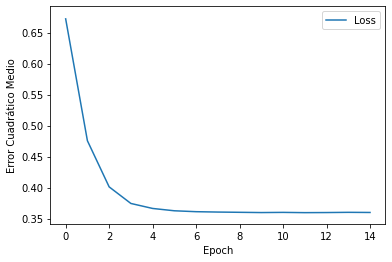


 Evalar el modelo de regresión lineal contra el conjunto de prueba:
3/3 [==============================] - 0s 5ms/step - loss: 0.3951 - mean_squared_error: 0.3951


[0.3950660526752472, 0.3950660526752472]

In [ ]:
learning_rate = 0.01
epochs = 15
batch_size = 1000
label_name = "median_house_value"

my_model = crear_modelo(learning_rate, my_feature_layer)

epochs, mse = train(my_model, train_df_norm, epochs, batch_size, label_name)
loss_curve(epochs, mse)

test_features = {name:np.array(value) for name, value in test_df_norm.items()}
test_label = np.array(test_features.pop(label_name)) 
print("\n Evalar el modelo de regresión lineal contra el conjunto de prueba:")
my_model.evaluate(x = test_features, y = test_label, batch_size=batch_size)

**Definir modelo de Red Neuronal**

In [ ]:
def crear_modelo(my_learning_rate, my_feature_layer):

  model = tf.keras.models.Sequential()

  model.add(my_feature_layer)

  model.add(tf.keras.layers.Dense(units=20, 
                                  activation='relu', 
                                  name='Hidden1'))   # primera capa de 20 neuronas y activación relu
  
  model.add(tf.keras.layers.Dense(units=12, 
                                  activation='relu', 
                                  name='Hidden2'))   # segunda capa de 12 neuronas y activación relu
  
  model.add(tf.keras.layers.Dense(units=1,  
                                  name='Output'))    # capa de salida                         
  
  model.compile(optimizer=tf.keras.optimizers.Adam(lr=my_learning_rate),
                loss="mean_squared_error",
                metrics=[tf.keras.metrics.MeanSquaredError()])

  return model

**Definir función de entrenamiento**

In [ ]:
def train(model, dataset, epochs, label_name,
                batch_size=None):

  features = {name:np.array(value) for name, value in dataset.items()}
  label = np.array(features.pop(label_name))
  history = model.fit(x=features, y=label, batch_size=batch_size,
                      epochs=epochs, shuffle=True) 

  epochs = history.epoch

  hist = pd.DataFrame(history.history)
  mse = hist["mean_squared_error"]

  return epochs, mse

**Entrenamiento del modelo**

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


17/17 [==============================] - 1s 4ms/step - loss: 0.6559 - mean_squared_error: 0.6559
Epoch 2/20
17/17 [==============================] - 0s 4ms/step - loss: 0.3799 - mean_squared_error: 0.3799
Epoch 3/20
17/17 [==============================] - 0s 4ms/step - loss: 0.3491 - mean_squared_error: 0.3491
Epoch 4/20
17/17 [==============================] - 0s 4ms/step - loss: 0.3421 - mean_squared_error: 0.3421
Epoch 5/20
17/17 [==============================] - 0s 5ms/step - loss: 0.3380 - mean_squared_error: 0.3380
Epoch 6/20
17/17 [==============================] - 0s 4ms/step - loss: 0.3366 - mean_squared_error: 0.3366
Epoch 7/20
17/17 [==============================] - 0s 4ms/step - loss: 0.3341 - mean_squared_error: 0.3341
Epoch 8/20
17/17 [==============================] - 0s 4ms/step - loss: 0.3341 - mean_squared_error: 0.3341
Epoch 9/20
17/17 [==============================] - 0s 5ms/step - loss: 0.3322 - mean_squared_error: 0.3322
Epoch 10/20
17/17 [====================

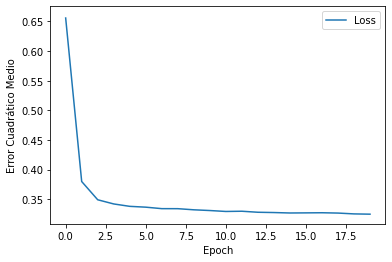


 Evaluar el nuevo modelo con el conjunto de validación:
3/3 [==============================] - 0s 7ms/step - loss: 0.3669 - mean_squared_error: 0.3669


[0.36686381697654724, 0.36686381697654724]

In [ ]:
learning_rate = 0.01
epochs = 20
batch_size = 1000

label_name = "median_house_value"

my_model = crear_modelo(learning_rate, my_feature_layer)

epochs, mse = train(my_model, train_df_norm, epochs, 
                          label_name, batch_size)
loss_curve(epochs, mse)

test_features = {name:np.array(value) for name, value in test_df_norm.items()}
test_label = np.array(test_features.pop(label_name)) 
print("\n Evaluar el nuevo modelo con el conjunto de validación:")
my_model.evaluate(x = test_features, y = test_label, batch_size=batch_size)

En comparación al modelo anterior, la red neuronal profunda (segundo modelo) ofrece mejores resultados que el modelo de realción lineal, lo que sugiere que la red neuronal hará mejores predicciones.  

Muchas respuestas son posibles si se modifican el número de capas y el número de neuronas por capa: 
- Dos capas superaron a una capa, pero, probando con tres capas no funcionó significativamente mejor que dos capas. En otras palabras, dos capas parecían lo mejor.
- A medida que reduje el número de nodos en cada capa (10 y 6), por debajo del anterior, la pérdida de prueba aumentó.

**Regularizar la red neuronal**

Si se observan con atención los resultados de los modelos obtenidos, veremos que, en ambos casos, el conjunto de prueba es mayor que la pérdida frente al conjunto de entrenamiento. En otras palabras, la red neuronal profunda se está sobreajustando a los datos del conjunto de entrenamiento. 

Para reducir el sobreajuste, voy a regularizar el modelo. Siendo posible regularizar de las siguientes maneras:

- Regularización L1
- Regularización L2
- Regularización de la deserción


Epoch 1/140


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


17/17 [==============================] - 1s 5ms/step - loss: 1.7319 - mean_squared_error: 0.6181
Epoch 2/140
17/17 [==============================] - 0s 5ms/step - loss: 0.7498 - mean_squared_error: 0.4193
Epoch 3/140
17/17 [==============================] - 0s 4ms/step - loss: 0.5493 - mean_squared_error: 0.3909
Epoch 4/140
17/17 [==============================] - 0s 5ms/step - loss: 0.4836 - mean_squared_error: 0.3794
Epoch 5/140
17/17 [==============================] - 0s 4ms/step - loss: 0.4562 - mean_squared_error: 0.3728
Epoch 6/140
17/17 [==============================] - 0s 4ms/step - loss: 0.4428 - mean_squared_error: 0.3695
Epoch 7/140
17/17 [==============================] - 0s 4ms/step - loss: 0.4371 - mean_squared_error: 0.3692
Epoch 8/140
17/17 [==============================] - 0s 4ms/step - loss: 0.4316 - mean_squared_error: 0.3674
Epoch 9/140
17/17 [==============================] - 0s 5ms/step - loss: 0.4291 - mean_squared_error: 0.3667
Epoch 10/140
17/17 [===========

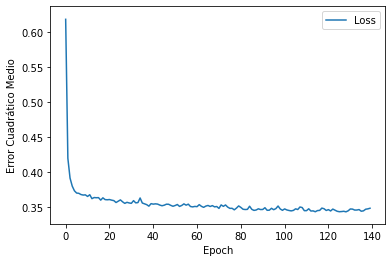


 Evaluar el nuevo modelo con el cojunto de validación:
3/3 [==============================] - 0s 6ms/step - loss: 0.4050 - mean_squared_error: 0.3767


[0.40496212244033813, 0.3767023980617523]

In [ ]:
# En mi siguiente solución utilizo la regularización L2

def crear_modelo(my_learning_rate, my_feature_layer):

  model = None

  model = tf.keras.models.Sequential()

  model.add(my_feature_layer)

  model.add(tf.keras.layers.Dense(units=20, 
                                  activation='relu',
                                  kernel_regularizer=tf.keras.regularizers.l2(0.04),
                                  name='Hidden1'))    # añado la regularización L2 con una fuerza de 0.04
  
  model.add(tf.keras.layers.Dense(units=12, 
                                  activation='relu', 
                                  kernel_regularizer=tf.keras.regularizers.l2(0.04),
                                  name='Hidden2'))    # añado la regularización L2 con una fuerza de 0.04

  model.add(tf.keras.layers.Dense(units=1,  
                                  name='Output'))                              
  
  model.compile(optimizer=tf.keras.optimizers.Adam(lr=my_learning_rate),
                loss="mean_squared_error",
                metrics=[tf.keras.metrics.MeanSquaredError()])

  return model     

learning_rate = 0.007
epochs = 140
batch_size = 1000

label_name = "median_house_value"

my_model = crear_modelo(learning_rate, my_feature_layer)

# Train the model on the normalized training set.
epochs, mse = train(my_model, train_df_norm, epochs, 
                          label_name, batch_size)
loss_curve(epochs, mse)

test_features = {name:np.array(value) for name, value in test_df_norm.items()}
test_label = np.array(test_features.pop(label_name)) # isolate the label
print("\n Evaluar el nuevo modelo con el cojunto de validación:")
my_model.evaluate(x = test_features, y = test_label, batch_size=batch_size) 